# Tutorial 1 - 4-th order Runge-Kutta (RK4) integrator for nuclear dynamics 

In this tutorial, we will learn:

* how to integrate Hamiltonian equations of motion using RK4 integrator


We are going to integrate Newtonian equations of motion:

\\[ \frac{dq}{dt} = \frac{p}{m}  \\]   (1a)

\\[ \frac{dp}{dt} = F = -\frac{dV}{dq}  \\]   (1b)


The current implementation of the RK4 integrator in Libra solves the ODE of the general form:

\\[ \frac{dZ}{dt} = f(Z) \\]   (2)

where Z is a complex-valued n x m matrix of arbitrary dimensions.


One can realize that the Hamiltonian equations of motion, Eqs.1,  can be cast into form Eq. 2 by associating the real and imaginary components of the Z matrix elements with the coordinates and conjugate momenta of our degrees of freedom:

\\[ Z_{ij} = q_{ij} + i * p_{ij}  \\]   (3)

Furthermore, it is convenient (and is the common convention in Libra) to associate rows of the Z matrix with the nuclear degrees of freedom (DOFs) and the columns of the matrix Z with the individual trajectories.


In [12]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

All we need to define on the "user side" is the way, the time-derivatives of the matrix Z are computed in terms of the matrix Z itself. This is done in the function below. 

The function takes the Z matrix as the main argument and returns the dZ/dt matrix of the same dimensionality.

Note, the function can also take any additional parameters, which in this case can include the force constants and particle masses.

Keep in mind that the name of the function doesn't matter - all we require is to obey the format of the input and output variables and the interface of the function.

In this example, we assume the Harmonic potential of the form:

\\[ V(q) = \frac{1}{2} \sum_{i} k_{i} * (q_{i}-q0_{i})^2  \\]

In [13]:
def derivatives(Z, params):
    ndof = Z.num_of_rows
    ntraj = Z.num_of_cols
    mass = params["mass"]     # list of dof items
    k = params["force_const"] # -
    q0 = params["q0"]         # -
        
    q = Z.real()
    p = Z.imag()
    
    der = CMATRIX(ndof, ntraj)
    
    for traj in range(ntraj):
        
        for dof in range(ndof):
            
            qi =  q.get(dof, traj)
            pi =  p.get(dof, traj)
            
            val1 = pi/mass[dof]
            val2 = -k[dof]*(qi-q0[dof])
            
            dzdt = val1*(1.0+0.0j)+val2*(0.0+1.0j)
            der.set(dof, traj, dzdt )
            
    return der


Next, lets define the function to compute energies, averaged over all trajectories 

In [14]:
def energies(Z, params):
    ndof = Z.num_of_rows
    ntraj = Z.num_of_cols
    
    mass = params["mass"]     # list of dof items
    k = params["force_const"] # -
    q0 = params["q0"]         # -
        
    q = Z.real()
    p = Z.imag()
    
    ekin, epot = 0.0, 0.0
    
    for traj in range(ntraj):        
        for dof in range(ndof):
            
            qi =  q.get(dof, traj)
            pi =  p.get(dof, traj)   
            
            ekin += 0.5*pi*pi/mass[dof]
            epot += 0.5*k[dof]*(qi-q0[dof])**2
    ekin = ekin / ntraj
    epot = epot / ntraj
    
    etot = ekin + epot
    
    return ekin, epot, etot

And a function to plot the energies vs time as well as the phase space portraits

In [15]:
def plot(T, Ekin, Epot, Etot, q, p):
    
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,2,1)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(T, Ekin, label='Kinetic energy', linewidth=2, color = colors["11"]) 
    plt.plot(T, Epot, label='Potential energy', linewidth=2, color = colors["21"]) 
    plt.plot(T, Etot, label='Total energy', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Phase space')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momenta, a.u.')
    plt.plot(q, p, label='', linewidth=2, color = colors["11"])     
    plt.legend()
        
    plt.show()
    plt.close()

Finally, lets define the final, "main" function to do the integration.

Note how the function calls the **RK4** function defined in the *libintegrators* library of Libra

In [16]:
def run_simulations():
    
    # Initial conditions
    Z = CMATRIX(1, 1)
    Z.set(0,0, 0.1+0.01j)

    # Potential
    params = {"mass":[1000.0], "force_const":[0.001], "q0":[0.0]}

    # Simulation parameters
    dt = 1.0*units.fs2au
    nsteps = 500

    T, Ekin, Epot, Etot, q, p = [], [], [], [], [], []
    for step in range(nsteps):    
        ekin, epot, etot = energies(Z, params)
    
        T.append(step*dt)
        Ekin.append(ekin)
        Epot.append(epot)
        Etot.append(etot)
        q.append(Z.get(0,0).real)
        p.append(Z.get(0,0).imag)
        #print(F"step = {step} ekin = {ekin} epot = {epot} etot = {etot}")
    
        Z = RK4(Z, dt, derivatives, params)
    
    return T, Ekin, Epot, Etot, q, p

Finally, we simply call the simulation function and plot the evolved variables:

In [17]:
T, Ekin, Epot, Etot, q, p = run_simulations()

No handles with labels found to put in legend.


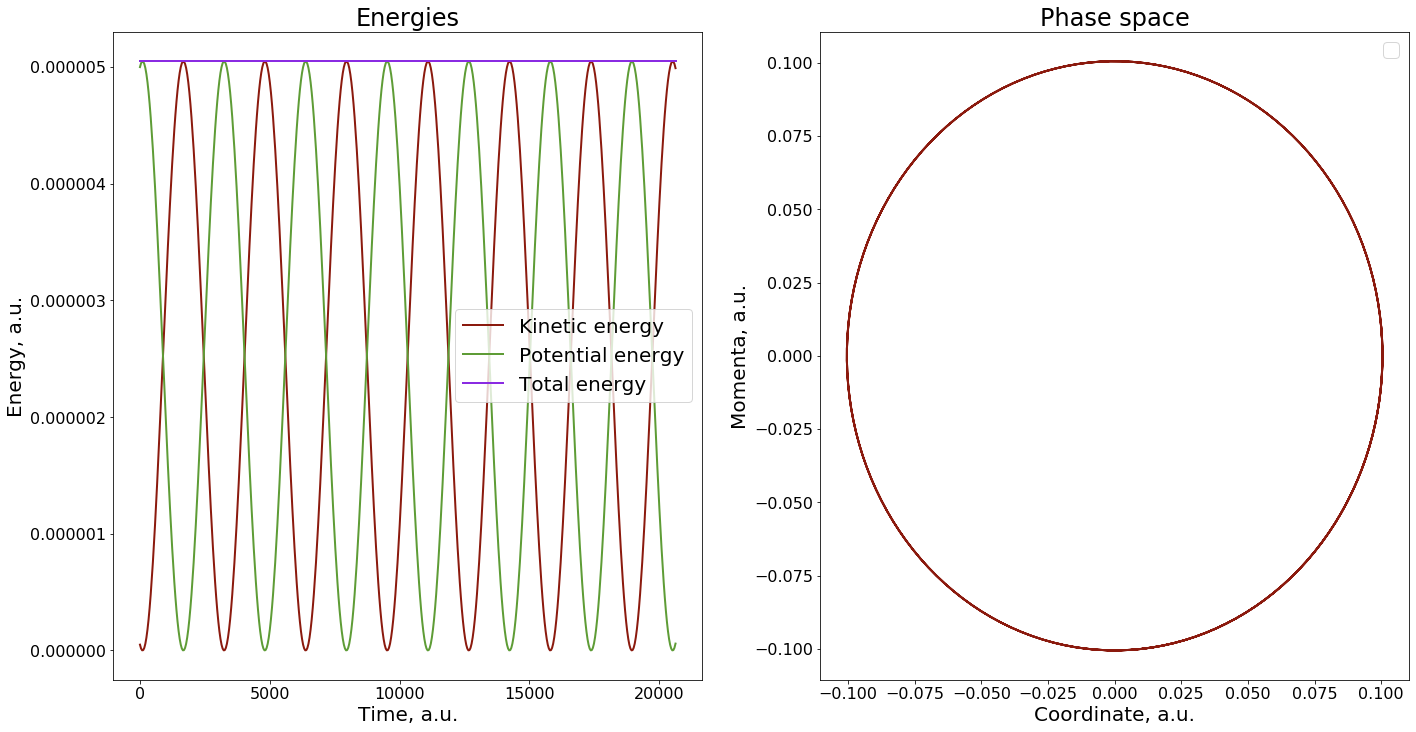

In [18]:
plot(T, Ekin, Epot, Etot, q, p)